In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import lightgbm as lgb
import matplotlib

In [2]:
df_csv = pd.read_csv('fraud_data.csv')

In [3]:
print(df_csv)

     TransactionID  Amount   Time     Location MerchantCategory  \
0                1  375.17  47605      Houston           Travel   
1                2  950.76  38088  Los Angeles      Electronics   
2                3  732.26  78752        Miami           Travel   
3                4  599.06  55284     New York        Groceries   
4                5  156.86  57043     New York        Groceries   
..             ...     ...    ...          ...              ...   
495            496  354.00  48770      Houston           Travel   
496            497  584.07  78623        Miami        Groceries   
497            498   78.66  75629        Miami         Clothing   
498            499  974.42  52603  Los Angeles      Electronics   
499            500  986.22  81974      Chicago      Electronics   

     CardHolderAge  IsFraud  
0             18.0        0  
1             28.0        0  
2             20.0        0  
3             69.0        0  
4             79.0        0  
..             

In [4]:
shape = df_csv.shape
print('shape = {}'.format(shape))

shape = (500, 7)


In [5]:
df_csv.isnull().sum()

TransactionID        0
Amount              25
Time                 0
Location            25
MerchantCategory     0
CardHolderAge       24
IsFraud              0
dtype: int64

In [6]:
df_csv.isnull().sum() /len(df_csv) *100

TransactionID       0.0
Amount              5.0
Time                0.0
Location            5.0
MerchantCategory    0.0
CardHolderAge       4.8
IsFraud             0.0
dtype: float64

In [7]:
df_csv.dtypes

TransactionID         int64
Amount              float64
Time                  int64
Location             object
MerchantCategory     object
CardHolderAge       float64
IsFraud               int64
dtype: object

In [8]:
df_csv.MerchantCategory.duplicated().sum

<bound method Series.sum of 0      False
1      False
2       True
3      False
4       True
       ...  
495     True
496     True
497     True
498     True
499     True
Name: MerchantCategory, Length: 500, dtype: bool>

In [9]:
df_csv['IsFraud'].value_counts(normalize=True) * 100

IsFraud
0    94.6
1     5.4
Name: proportion, dtype: float64

In [10]:
fraud_ratio = df_csv['IsFraud'].value_counts()[1] / len(df_csv)
print(f"Fraud ratio: {fraud_ratio:.2%}")

Fraud ratio: 5.40%


In [13]:
df = df_csv.drop('TransactionID', axis =1)
print(df)

     Amount   Time     Location MerchantCategory  CardHolderAge  IsFraud
0    375.17  47605      Houston           Travel           18.0        0
1    950.76  38088  Los Angeles      Electronics           28.0        0
2    732.26  78752        Miami           Travel           20.0        0
3    599.06  55284     New York        Groceries           69.0        0
4    156.86  57043     New York        Groceries           79.0        0
..      ...    ...          ...              ...            ...      ...
495  354.00  48770      Houston           Travel           21.0        0
496  584.07  78623        Miami        Groceries           64.0        1
497   78.66  75629        Miami         Clothing           78.0        0
498  974.42  52603  Los Angeles      Electronics           21.0        1
499  986.22  81974      Chicago      Electronics           37.0        0

[500 rows x 6 columns]


In [14]:
pd.to_datetime(df_csv['Time'], unit='s')

0     1970-01-01 13:13:25
1     1970-01-01 10:34:48
2     1970-01-01 21:52:32
3     1970-01-01 15:21:24
4     1970-01-01 15:50:43
              ...        
495   1970-01-01 13:32:50
496   1970-01-01 21:50:23
497   1970-01-01 21:00:29
498   1970-01-01 14:36:43
499   1970-01-01 22:46:14
Name: Time, Length: 500, dtype: datetime64[ns]

In [15]:
# le = LabelEncoder()
# le.fit_transform(df_csv['Location'])
le = LabelEncoder()
df_csv['Location'] = le.fit_transform(df_csv['Location'])
print(df_csv['Location'])

0      1
1      2
2      3
3      4
4      4
      ..
495    1
496    3
497    3
498    2
499    0
Name: Location, Length: 500, dtype: int64


In [16]:
le = LabelEncoder()
df_csv['MerchantCategory'] = le.fit_transform(df_csv['MerchantCategory'])
print(df_csv['MerchantCategory'])

0      4
1      1
2      4
3      3
4      3
      ..
495    4
496    3
497    0
498    1
499    1
Name: MerchantCategory, Length: 500, dtype: int64


In [17]:
fraud_rate = df_csv.groupby('MerchantCategory')['IsFraud'].mean()
df_csv['MerchantCategory'].map(fraud_rate)

0      0.040000
1      0.038835
2      0.040000
3      0.072727
4      0.072727
         ...   
495    0.040000
496    0.072727
497    0.076923
498    0.038835
499    0.038835
Name: MerchantCategory, Length: 500, dtype: float64

In [18]:
scaler = StandardScaler()
scaler.fit_transform(df_csv[['Amount', 'CardHolderAge']])

array([[-2.54893608e-01, -1.58212727e+00],
       [ 2.96782308e-01, -1.04615646e+00],
       [ 8.73603449e-02, -1.47493311e+00],
       [-4.03055840e-02,  1.15132384e+00],
       [-4.64133465e-01,  1.68729465e+00],
       [-4.64152634e-01, -4.02991495e-01],
       [-5.57898914e-01, -2.42200253e-01],
       [ 2.15840959e-01, -1.42133603e+00],
       [-3.79573743e-02, -6.70976898e-01],
       [ 6.44533201e-02,  1.31211508e+00],
       [-5.93812145e-01, -1.31414187e+00],
       [ 3.15165435e-01,  2.40173473e-01],
       [ 1.83541095e-01, -4.56588575e-01],
       [-4.10201319e-01,             nan],
       [-4.39424549e-01, -8.31768140e-01],
       [-4.37910193e-01, -4.56588575e-01],
       [-3.22205757e-01,  1.58010049e+00],
       [-1.11068163e-01,  3.47367634e-01],
       [ 6.72867172e+00,  1.15132384e+00],
       [-3.34665644e-01,  6.15353037e-01],
       [-2.76731745e-02, -9.92559381e-01],
       [-4.79957522e-01,  8.83338440e-01],
       [-3.33793452e-01,  9.90532601e-01],
       [-2.

In [19]:
print(df_csv['Amount'].mean())
print(df_csv['Amount'].std())
print(df_csv['CardHolderAge'].mean())
print(df_csv['CardHolderAge'].std())

641.1127530842106
1044.4480647858059
47.51890756302521
18.67736202673582


In [20]:
scaler = MinMaxScaler()
scaler.fit_transform(df_csv[['Amount', 'CardHolderAge']])

array([[3.81094718e-02, 1.13043478e-01],
       [9.75373684e-02, 2.00000000e-01],
       [7.49779157e-02, 1.30434783e-01],
       [6.12254255e-02, 5.56521739e-01],
       [1.55696360e-02, 6.43478261e-01],
       [1.55675711e-02, 3.04347826e-01],
       [5.46898952e-03, 3.30434783e-01],
       [8.88181657e-02, 1.39130435e-01],
       [6.14783805e-02, 2.60869565e-01],
       [7.25103142e-02, 5.82608696e-01],
       [1.60032731e-03, 1.56521739e-01],
       [9.95176444e-02, 4.08695652e-01],
       [8.53387444e-02, 2.95652174e-01],
       [2.13793404e-02,            nan],
       [1.82313417e-02, 2.34782609e-01],
       [1.83944718e-02, 2.95652174e-01],
       [3.08584404e-02, 6.26086957e-01],
       [5.36027051e-02, 4.26086957e-01],
       [7.90396432e-01, 5.56521739e-01],
       [2.95162304e-02, 4.69565217e-01],
       [6.25862199e-02, 2.08695652e-01],
       [1.38650293e-02, 5.13043478e-01],
       [2.96101851e-02, 5.30434783e-01],
       [3.72659445e-02,            nan],
       [4.651790

In [21]:
df_csv['IsFraud'].value_counts(normalize=True) * 100

IsFraud
0    94.6
1     5.4
Name: proportion, dtype: float64

In [ ]:
pip install imbalanced-learn

In [24]:
from imblearn.over_sampling import SMOTE

X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)
print("Original shape:", X.shape, y.shape)
print("Resampled shape:", X_res.shape, y_res.shape)
print("Class distribution after SMOTE:", y_res.value_counts())

ValueError: could not convert string to float: 'Houston'

In [23]:
print(df.isna().sum())  # Shows count of NaNs per column

Amount              25
Time                 0
Location            25
MerchantCategory     0
CardHolderAge       24
IsFraud              0
dtype: int64


In [25]:
from sklearn.impute import SimpleImputer
num_cols = ['Amount', 'CardHolderAge']  # Add any other numerics
cat_cols = ['Location', 'MerchantCategory']  # Add any other categoricals

# Impute numerics (use 'median' if data is skewed)
# num_imputer = SimpleImputer(strategy='mean')  
num_imputer = SimpleImputer(strategy='median') 
cat_imputer = SimpleImputer(strategy='most_frequent')
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Features & target
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
le = LabelEncoder()
for col in ['Location', 'MerchantCategory']:
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [30]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': True,   # handles imbalance automatically
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500, early_stopping_rounds=50)
model = lgb.train(params, train_data, valid_sets=[test_data], 
                  num_boost_round=500, 
                  callbacks=[lgb.early_stopping(50)])  # NEW way

[LightGBM] [Info] Number of positive: 22, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055000 -> initscore=-2.843852
[LightGBM] [Info] Start training from score -2.843852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [31]:
y_prob = model.predict(X_test)  # probability of fraud
y_pred = (y_prob > 0.3).astype(int)  # try threshold 0.3 instead of 0.5

In [32]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[95  0]
 [ 5  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        95
           1       0.00      0.00      0.00         5

    accuracy                           0.95       100
   macro avg       0.47      0.50      0.49       100
weighted avg       0.90      0.95      0.93       100


ROC AUC Score: 0.5347368421052632


D:\Machine Learning Projects\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Machine Learning Projects\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Machine Learning Projects\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

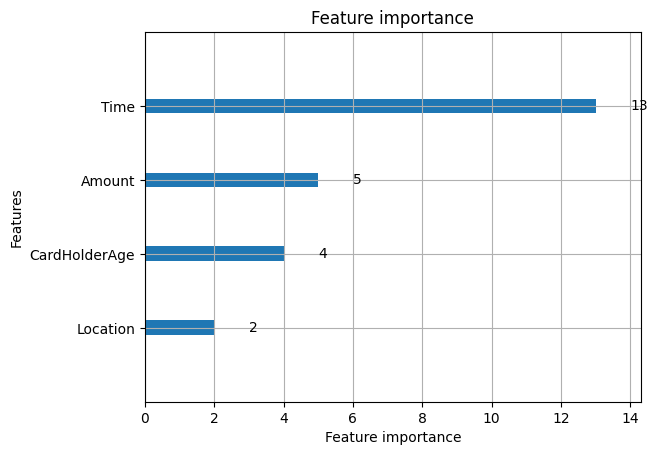

In [33]:
lgb.plot_importance(model, max_num_features=10)

In [34]:
df_csv = df_csv.drop('TransactionID', axis =1)
print(df_csv)

     Amount   Time  Location  MerchantCategory  CardHolderAge  IsFraud
0    375.17  47605         1                 4           18.0        0
1    950.76  38088         2                 1           28.0        0
2    732.26  78752         3                 4           20.0        0
3    599.06  55284         4                 3           69.0        0
4    156.86  57043         4                 3           79.0        0
..      ...    ...       ...               ...            ...      ...
495  354.00  48770         1                 4           21.0        0
496  584.07  78623         3                 3           64.0        1
497   78.66  75629         3                 0           78.0        0
498  974.42  52603         2                 1           21.0        1
499  986.22  81974         0                 1           37.0        0

[500 rows x 6 columns]


In [36]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

lgbm = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best AUC:", grid.best_score_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[LightGBM] [Info] Number of positive: 22, number of negative: 378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055000 -> initscore=-2.843852
[LightGBM] [Info] Start training from score -2.843852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[